 Load training and test data, separate features (X) and target (y).
 Identify numeric columns and apply StandardScaler via ColumnTransformer
 to normalize inputs before model training.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Load data
train = pd.read_csv("train_mlprojfinal.csv")
test = pd.read_csv("test_mlprojfinal.csv")

X = train.drop(columns=["category"])
y = train["category"]

# Preprocessing
num_cols = ["signal_strength", "response_level"]
cat_cols = []  # none in features, only target

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols)
])

Define a helper function 'evaluate_model' to train and test models, printing key metrics.
Build an SVM pipeline with preprocessing and tune hyperparameters using GridSearchCV.
Split the data into train/validation sets and evaluate the best SVM model.


In [2]:
def evaluate_model(model, X_train, y_train, X_valid, y_valid, name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    print(f"\n=== {name} ===")
    print(classification_report(y_valid, y_pred))
    print(confusion_matrix(y_valid, y_pred))


# SVM with GridSearchCV

svm_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", SVC(probability=True))
])

param_grid = {
    "clf__kernel": ["linear", "rbf"],
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"]
}

svm_cv = GridSearchCV(
    svm_pipe,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="accuracy",
    n_jobs=-1
)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
evaluate_model(svm_cv, X_train, y_train, X_valid, y_valid, "SVM")


=== SVM ===
              precision    recall  f1-score   support

     Group_A       0.94      0.98      0.96        51
     Group_B       1.00      0.99      0.99       142
     Group_C       0.99      0.99      0.99        96

    accuracy                           0.99       289
   macro avg       0.98      0.99      0.98       289
weighted avg       0.99      0.99      0.99       289

[[ 50   0   1]
 [  2 140   0]
 [  1   0  95]]


Define a custom PyTorch-based MLP classifier:
 - __init__ sets model hyperparameters (hidden size, layers, dropout, lr, etc.).
- _build_model builds a feedforward network with ReLU and Dropout.
- fit trains the model using Adam optimizer and CrossEntropyLoss on one-hot encoded labels.
- predict returns class indices from the trained network.
- score computes accuracy by comparing predictions with true labels.


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class TorchMLPClassifier:
    def __init__(self, hidden_dim=64, hidden_layers=2, dropout=0.2, lr=1e-3, batch_size=64, epochs=20):
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs

    def _build_model(self, input_dim, output_dim):
        layers = []
        in_dim = input_dim
        for _ in range(self.hidden_layers):
            layers += [nn.Linear(in_dim, self.hidden_dim), nn.ReLU(), nn.Dropout(self.dropout)]
            in_dim = self.hidden_dim
        layers += [nn.Linear(in_dim, output_dim)]
        return nn.Sequential(*layers)

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = pd.get_dummies(y).values.astype(np.float32)  # one-hot
        dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        input_dim = X.shape[1]
        output_dim = y.shape[1]
        self.model = self._build_model(input_dim, output_dim)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(self.epochs):
            for xb, yb in loader:
                optimizer.zero_grad()
                logits = self.model(xb)
                loss = criterion(logits, torch.argmax(yb, dim=1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        with torch.no_grad():
            logits = self.model(torch.from_numpy(X))
            preds = torch.argmax(logits, dim=1).numpy()
        return preds

    def score(self, X, y):
        preds = self.predict(X)
        return (preds == pd.Categorical(y).codes).mean()

Wrap the custom PyTorch MLP inside a scikit-learn compatible class (TorchWrapper).
LabelEncoder ensures string labels are converted to integers for training and back to strings for predictions.
Build a pipeline with preprocessing + TorchWrapper, then tune hyperparameters using GridSearchCV.
Finally, evaluate the best PyTorch MLP model on the validation set.


In [4]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder

class TorchWrapper(BaseEstimator):
    def __init__(self, hidden_dim=64, hidden_layers=2, dropout=0.2,
                 lr=1e-3, batch_size=64, epochs=20):
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.clf = TorchMLPClassifier(hidden_dim, hidden_layers,
                                      dropout, lr, batch_size, epochs)
        self.le_ = None  # label encoder

    def fit(self, X, y):
        # Encode string labels to integers
        self.le_ = LabelEncoder()
        y_enc = self.le_.fit_transform(y)
        self.clf.fit(X, y_enc)
        return self

    def predict(self, X):
        preds = self.clf.predict(X)
        # Map back to original string labels
        return self.le_.inverse_transform(preds)

    def score(self, X, y):
        y_enc = self.le_.transform(y)
        preds = self.clf.predict(X)
        return (preds == y_enc).mean()

torch_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", TorchWrapper())
])

torch_param_grid = {
    "clf__hidden_dim": [64, 128],
    "clf__hidden_layers": [1, 2],
    "clf__dropout": [0.1, 0.3],
    "clf__lr": [1e-3, 3e-4],
    "clf__epochs": [20, 40]
}

torch_cv = GridSearchCV(
    torch_pipe,
    param_grid=torch_param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring="accuracy",
    n_jobs=1
)

# Now evaluation works with string labels consistently
evaluate_model(torch_cv, X_train, y_train, X_valid, y_valid, "PyTorch MLP")



=== PyTorch MLP ===
              precision    recall  f1-score   support

     Group_A       0.87      0.80      0.84        51
     Group_B       0.97      0.97      0.97       142
     Group_C       0.94      0.98      0.96        96

    accuracy                           0.94       289
   macro avg       0.93      0.92      0.92       289
weighted avg       0.94      0.94      0.94       289

[[ 41   4   6]
 [  4 138   0]
 [  2   0  94]]


Now doing the same thing for Binary CLassification Dataset


In [5]:
print(train.columns)


Index(['sample_id', 'signal_strength', 'response_level', 'category'], dtype='object')



=== SVM ===
              precision    recall  f1-score   support

           0     0.8315    0.7829    0.8065      5642
           1     0.6596    0.7262    0.6913      3269

    accuracy                         0.7621      8911
   macro avg     0.7456    0.7545    0.7489      8911
weighted avg     0.7685    0.7621    0.7642      8911

[[4417 1225]
 [ 895 2374]]
ROC-AUC: 0.833


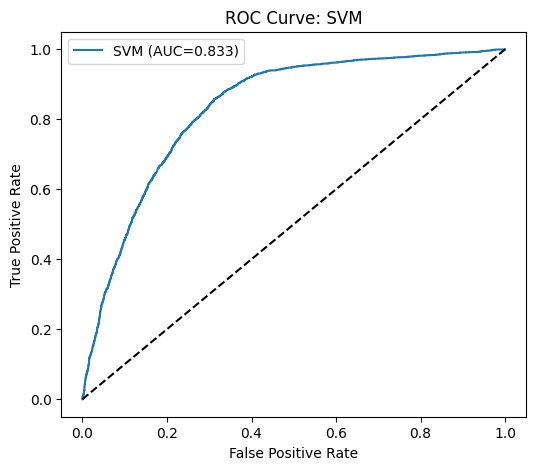

/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(



=== PyTorch Binary MLP ===
              precision    recall  f1-score   support

           0     0.8108    0.8066    0.8087      5642
           1     0.6692    0.6751    0.6721      3269

    accuracy                         0.7584      8911
   macro avg     0.7400    0.7409    0.7404      8911
weighted avg     0.7588    0.7584    0.7586      8911

[[4551 1091]
 [1062 2207]]
ROC-AUC: 0.8397


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


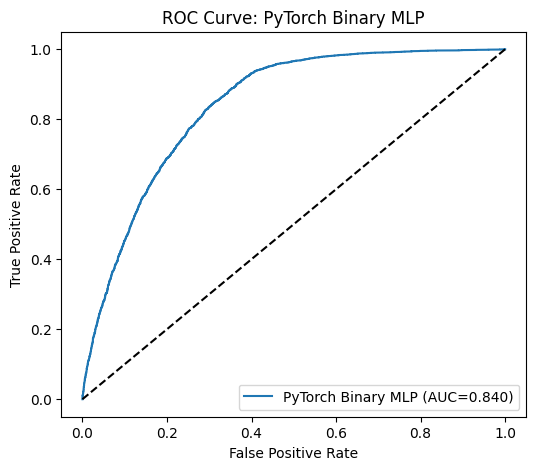

In [6]:
# Imports

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


# Load Data

TRAIN_PATH = "binary_train.csv"
TEST_PATH = "binary_test.csv"
TARGET_COL = "has_copd_risk"   # <-- confirmed target column

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

X = train.drop(columns=[TARGET_COL])
y = train[TARGET_COL]


# Preprocessing

num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])


# Evaluation Function

def evaluate_model(model, X_train, y_train, X_valid, y_valid, name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    print(f"\n=== {name} ===")
    print(classification_report(y_valid, y_pred, digits=4))
    print(confusion_matrix(y_valid, y_pred))

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_valid)[:,1]
        auc_val = roc_auc_score(y_valid, y_score)
        print("ROC-AUC:", round(auc_val,4))
        fpr, tpr, _ = roc_curve(y_valid, y_score)
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")
        plt.plot([0,1],[0,1],"k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve: {name}")
        plt.legend()
        plt.show()


# Train/Validation Split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


# SVM with GridSearchCV (optimized)

svm_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", SVC(probability=True, random_state=42))
])

svm_param_grid = {
    "clf__kernel": ["linear", "rbf"],   # fewer kernels
    "clf__C": [1],                      # single value
    "clf__gamma": ["scale"]             # single value
}

svm_cv = GridSearchCV(
    svm_pipe,
    param_grid=svm_param_grid,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # fewer folds
    scoring="accuracy",
    n_jobs=-1
)

evaluate_model(svm_cv, X_train, y_train, X_valid, y_valid, "SVM")


# PyTorch Binary MLP Classifier (optimized)

class TorchBinaryMLPClassifier:
    def __init__(self, hidden_dim=64, hidden_layers=1, dropout=0.2,
                 lr=1e-3, batch_size=128, epochs=15):   # fewer epochs, larger batch
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None

    def _build_model(self, input_dim):
        layers = []
        in_dim = input_dim
        for _ in range(self.hidden_layers):
            layers += [nn.Linear(in_dim, self.hidden_dim), nn.ReLU(), nn.Dropout(self.dropout)]
            in_dim = self.hidden_dim
        layers += [nn.Linear(in_dim, 1)]  # single output for binary
        return nn.Sequential(*layers)

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32).reshape(-1, 1)
        dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        input_dim = X.shape[1]
        self.model = self._build_model(input_dim)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.BCEWithLogitsLoss()

        for epoch in range(self.epochs):
            for xb, yb in loader:
                optimizer.zero_grad()
                logits = self.model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        with torch.no_grad():
            logits = self.model(torch.from_numpy(X))
            probs = torch.sigmoid(logits).numpy().reshape(-1)
        return (probs >= 0.5).astype(int)

    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float32)
        with torch.no_grad():
            logits = self.model(torch.from_numpy(X))
            probs = torch.sigmoid(logits).numpy().reshape(-1)
        return np.vstack([1 - probs, probs]).T

    def score(self, X, y):
        preds = self.predict(X)
        return (preds == y).mean()


# Torch Wrapper for GridSearchCV

from sklearn.base import BaseEstimator

class TorchBinaryWrapper(BaseEstimator):
    def __init__(self, hidden_dim=64, hidden_layers=1, dropout=0.2,
                 lr=1e-3, batch_size=128, epochs=15):
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.dropout = dropout
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.clf = TorchBinaryMLPClassifier(hidden_dim, hidden_layers,
                                            dropout, lr, batch_size, epochs)

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

    def score(self, X, y):
        return self.clf.score(X, y)

torch_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", TorchBinaryWrapper())
])

# Smaller grid for speed
torch_param_grid = {
    "clf__hidden_dim": [64],
    "clf__hidden_layers": [1],
    "clf__dropout": [0.2],
    "clf__lr": [1e-3],
    "clf__epochs": [15]
}

torch_cv = GridSearchCV(
    torch_pipe,
    param_grid=torch_param_grid,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),  # only 2 folds
    scoring="accuracy",
    n_jobs=1
)

evaluate_model(torch_cv, X_train, y_train, X_valid, y_valid, "PyTorch Binary MLP")
